## Setup

In [3]:
import ugradio
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import lstsq, inv, norm
from scipy.fft import fft, ifft, fftfreq, fftshift, ifftshift
from scipy.stats import norm, linregress
from scipy.optimize import curve_fit, least_squares
from scipy.signal import find_peaks, stft
from scipy.special import j1
from uncertainties import ufloat
import os
import glob
import time
from astropy.time import Time
from astropy.coordinates import EarthLocation
import astropy.units as u
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset

In [4]:
# Consistent Plot Params
titleSize = 15
axisSize = 15
legendSize = 13
graphSizeSingle = (8, 6)
graphSizeDouble = (15, 6)
graphSizeHorizontal = (20, 6)

## Data Extraction

In [5]:
def extractRawData(folder, filename):
    prefix = "ugastro\\Lab3Data\\" + folder
    raw_data = np.load(prefix + filename, allow_pickle=True)
    return raw_data

def getDataBlocks(data, buffer=10, num_blocks=2030):
    new_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        new_data[i] = normalize(block['corr01'])
    return new_data

def getRealImagData(data, buffer=10, num_blocks=2030):
    real_data = np.zeros((num_blocks, 1024), dtype=float)
    imag_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        real_data[i] = normalize(block['corr01'].real)
        imag_data[i] = normalize(block['corr01'].imag)
        #real_data[i] = block['corr01'].real
        #imag_data[i] = block['corr01'].imag
    return real_data, imag_data

def getComplexData(data, buffer=10, num_blocks=2030):
    complex_data = np.zeros((num_blocks, 1024), dtype=complex)
    for i, block in enumerate(data[buffer:num_blocks+buffer]):
        complex_data[i] = normalize(block['corr01'].real) + (1j * normalize(block['corr01'].imag))
        complex_data[i] = normalize(complex_data[i])

    return complex_data

def getDataSingleBlock(data, block=1):
    real = data['time_data'][block][:, 0]
    imag = data['time_data'][block][:, 1]
    return normalize(real + (1j * imag))

def getHorizonRawData(folder, extension="npy"):
    # Load and merge many files
    directory = "ugastro\\Lab3Data\\" + folder
    file_paths = sorted(glob.glob(os.path.join(directory, f"*.{extension}")))
    if not file_paths:
        print("No files found. Check the directory path and file extension.")
        return None
    
    data = []
    for file in file_paths:
        try:
            data.append(np.load(file, allow_pickle=True))
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if data:
        merged_data = np.concatenate(data, axis=0)
        return merged_data
    else:
        print("No valid data files loaded.")
        return None

def normalize(data):
    return (data - np.mean(data)) #/ np.std(data)

def getUnixTimes(data, buffer=0):
    # Takes raw data
    times = [(data[i+buffer]['time']) for i in range(len(data)-buffer)]

    return times

def getTimesJD(data, buffer=0):
    # Takes raw data
    times = [(data[i+buffer]['time']/86400)+2440587.5 for i in range(len(data)-buffer)]

    return times

def getTimesLocal(data):
    # Takes raw data
    times = [time.gmtime(data[i]['time']) for i in range(len(data))]
    return times

def timestepToSec(timestep):
    # Takes a time step in seconds and converts to a datetime object
    return 1.25 * timestep


In [6]:
# Week 1
folder = "Week1_Testing\\"
data_test_raw = extractRawData(folder, "test_observatin_data.npy")
data_test = getDataBlocks(data_test_raw)
data_test_2_raw = extractRawData(folder, "Mar12_test_observation_data.npz")
data_test_2 = getDataBlocks(data_test_2_raw['arr_0'])

data_horizon_raw_1 = extractRawData(folder, "Mar13_12hour_observation_data.npz")
data_horizon_1 = getDataBlocks(data_horizon_raw_1['arr_0'], )

data_horizon_raw_2 = getHorizonRawData("Mar15_Observation")

In [7]:
horizon_real, horizon_imag = getRealImagData(data_horizon_raw_2, buffer=0, num_blocks=28720)
print(len(horizon_real))
print(len(horizon_imag))

horizon_complex = getComplexData(data_horizon_raw_2, buffer=0, num_blocks=28720)
print(horizon_complex.shape)
print(horizon_complex[0])

28720
28720
(28720, 1024)
[6.18995466+0.02812842j 0.40605558+0.02812842j 0.40605558+0.02812842j ...
 0.40605558+0.02812842j 0.40605558+0.02812842j 0.40605558+0.02812842j]


In [8]:
time_data = getUnixTimes(data_horizon_raw_2, buffer=0)
time_data_jd = getTimesJD(data_horizon_raw_2, buffer=0)
LOC = EarthLocation(lat=37.873199*u.deg, lon=-122.257063*u.deg, height=120*u.m)
times = Time(time_data, format='unix', location=LOC)
LSTs = times.sidereal_time('apparent', longitude=LOC.lon).radian % (2 * np.pi)

RAs, DECs, HAs = np.zeros(len(time_data)), np.zeros(len(time_data)), np.zeros(len(time_data))
for i in range(len(time_data)):
    ra, dec = ugradio.coord.sunpos(time_data_jd[i])
    RAs[i] = np.radians(ra)
    HAs[i] = LSTs[i] - np.radians(ra)
    HAs[i] += 2*np.pi if HAs[i] < -4 else 0
    DECs[i] = np.radians(dec)
    
w_earth = (2 * np.pi) / (24 * 60 * 60)
wavelen = 0.025
L = np.radians(37.873199)
b_ew_guess = 20
b_ns_guess = 0

print(len(HAs))

28720


In [9]:
print(len(time_data))
step = 2000
for i in range(0, len(HAs), step):
    print(f"jd = {time_data_jd[i]}, RA = {RAs[i]}, LST = {LSTs[i]}, HAs = {HAs[i]}")

28720
jd = 2460750.1474417555, RA = 6.202195307541056, LST = 4.96218682183104, HAs = -1.2400084857100167
jd = 2460750.1763795596, RA = 6.2026573498283755, LST = 5.144506198724753, HAs = -1.0581511511036226
jd = 2460750.2053176025, RA = 6.203119382418845, LST = 5.326827079928264, HAs = -0.8762923024905813
jd = 2460750.2342548883, RA = 6.20358138945035, LST = 5.509143192679575, HAs = -0.6944381967707747
jd = 2460750.2631916376, RA = 6.204043374488607, LST = 5.691455924520362, HAs = -0.5125874499682448
jd = 2460750.2921294933, RA = 6.204505363802754, LST = 5.873775626062808, HAs = -0.3307297377399463
jd = 2460750.321067571, RA = 6.2049673433150305, LST = 6.056096729467852, HAs = -0.14887061384717892
jd = 2460750.3500040104, RA = 6.205429283360815, LST = 6.2384075080091845, HAs = 0.03297822464836919
jd = 2460750.3789423867, RA = 6.205891241064851, LST = 0.1375451829035466, HAs = 0.214839249018282
jd = 2460750.4078796506, RA = 6.206353167784735, LST = 0.31986115617218586, HAs = 0.3966932955

c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


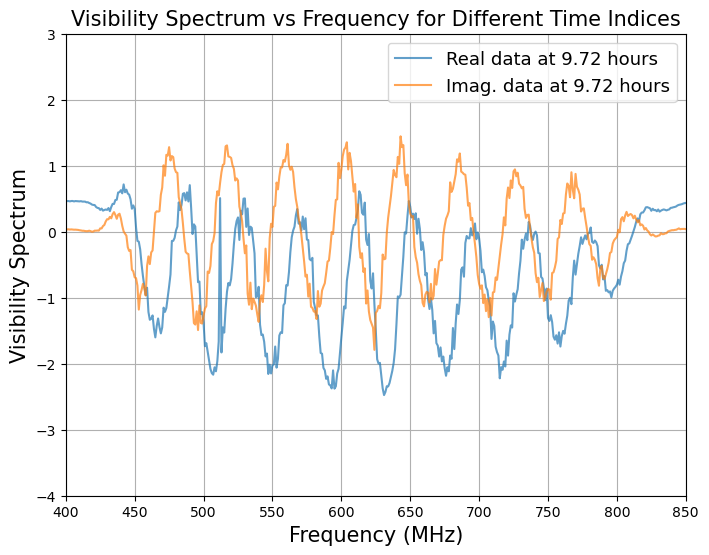

In [10]:
def plot_power_spectrum(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)

    for index in indices:
        spectrum = data[index]
        plt.plot(spectrum, label=f"time index = {index}", alpha=0.7)
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

def plot_power_spectrum_complex(data_real, data_imag, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [(x*1.25)/3600 for x in range(len(data_real))]

    for index in indices:
        spectrum_real = data_real[index]
        spectrum_imag = data_imag[index]
        plt.plot(spectrum_real, label=f"Real data at {round(times[index], 2)} hours", alpha=0.7)
        plt.plot(spectrum_imag, label=f"Imag. data at {round(times[index], 2)} hours", alpha=0.7)

    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum vs Frequency for Different Time Indices", size=titleSize)
    plt.grid()
    plt.show()

#plot_power_spectrum(data_horizon_2, indices=[23000, 28000], xlim=(400, 850), ylim=(-4, 3))
#plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[10000], xlim=(400, 850), ylim=(-4, 3))
#plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[23000], xlim=(400, 850), ylim=(-4, 3))
plot_power_spectrum_complex(horizon_real, horizon_imag, indices=[28000], xlim=(400, 850), ylim=(-4, 3))

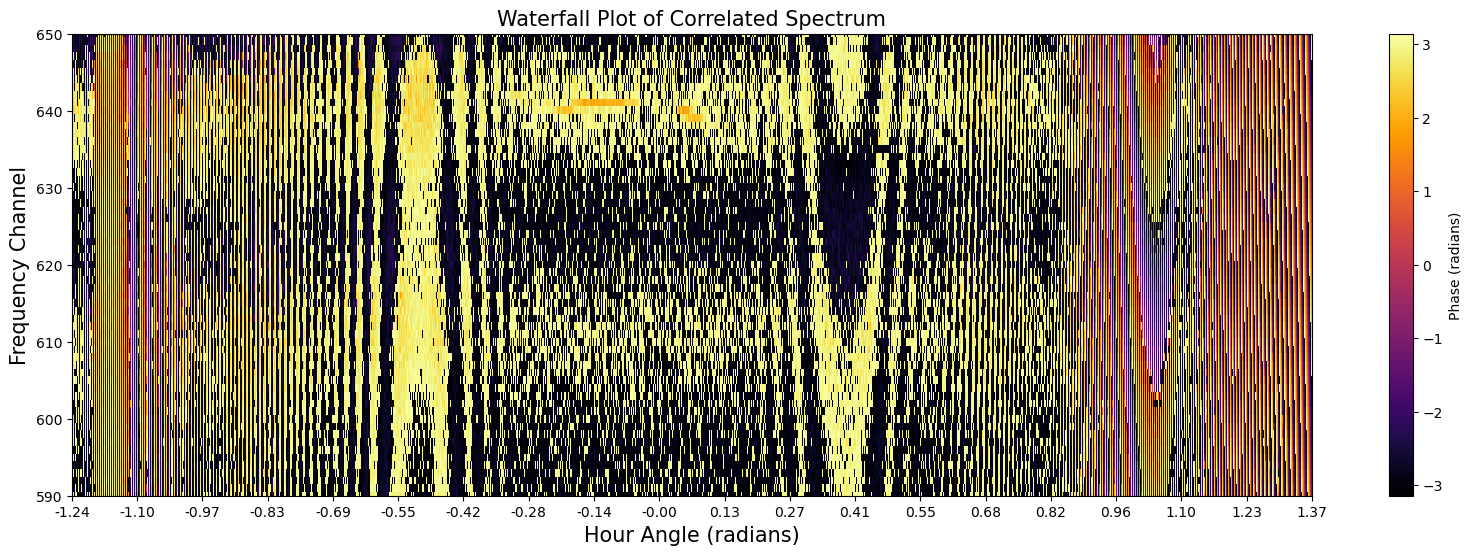

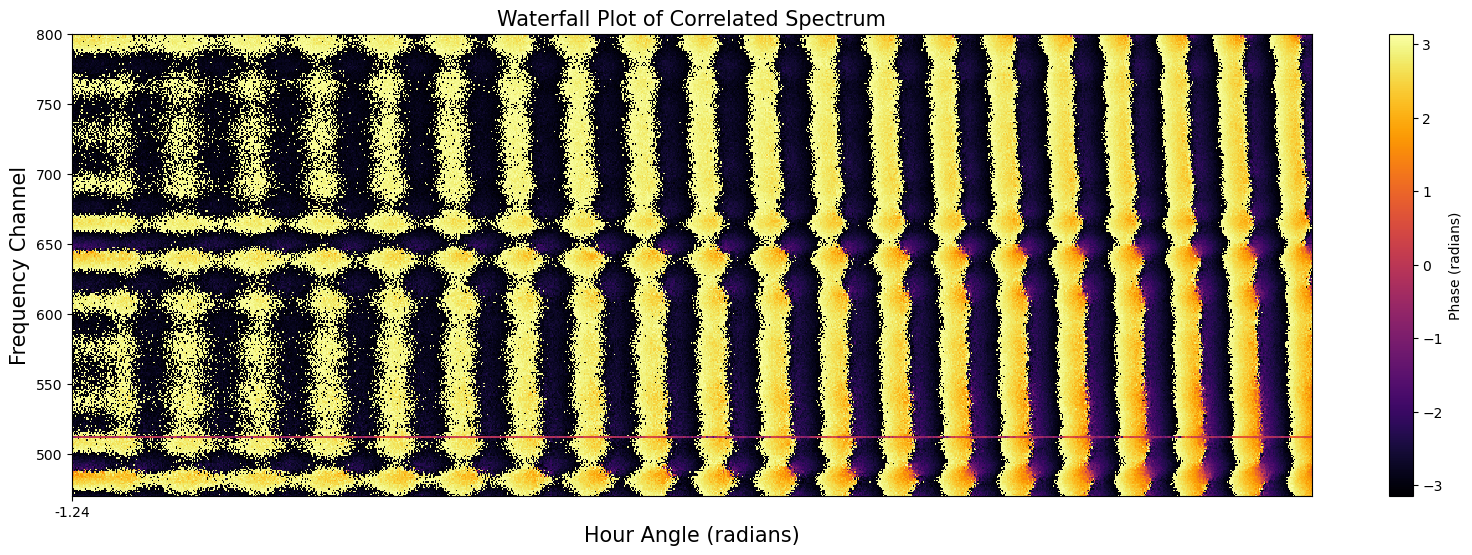

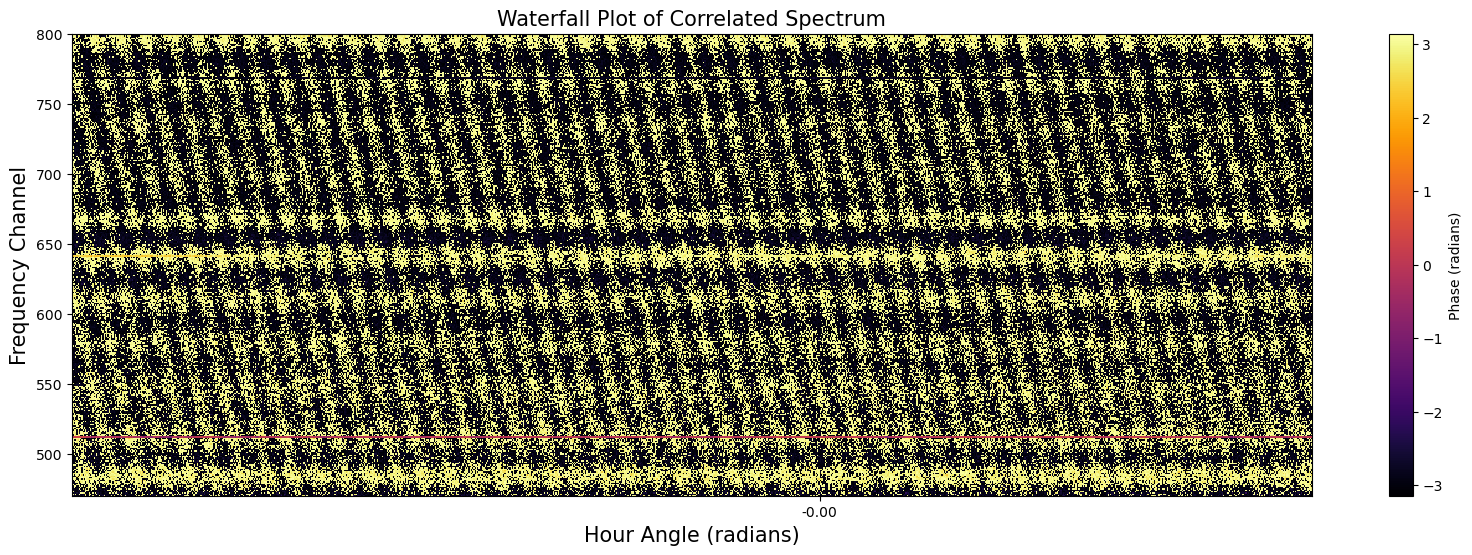

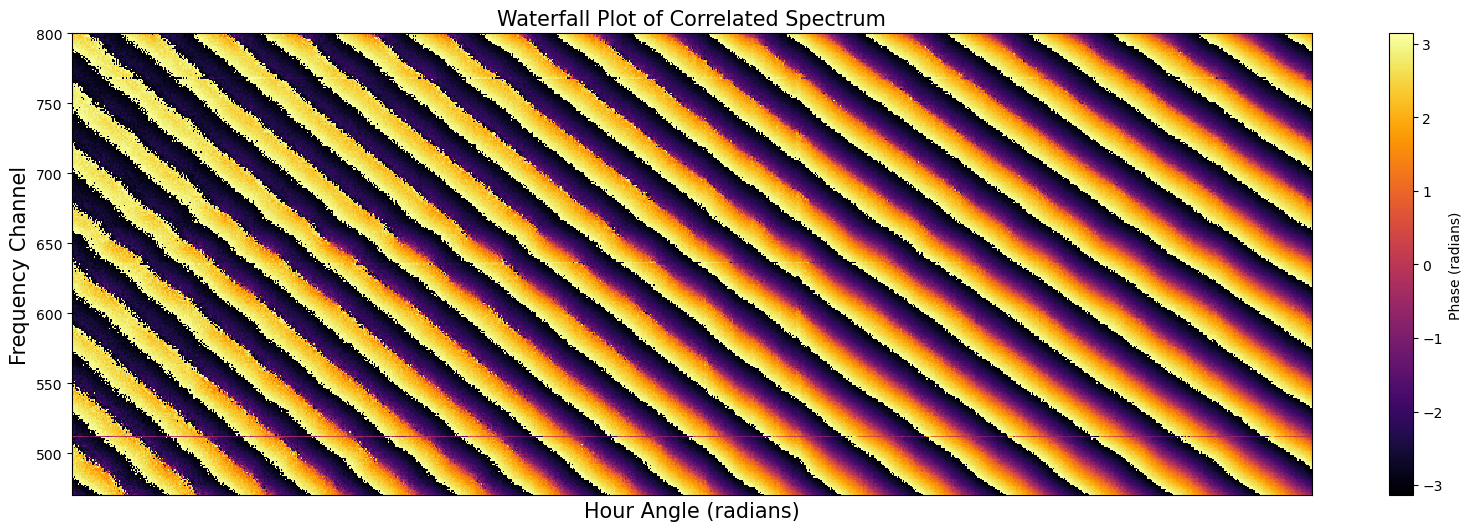

In [11]:
def plot_waterfall(data, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data), aspect='auto', cmap='inferno', norm='linear',
                interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_corr(data, baseline, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    plt.imshow(np.abs(data) - np.abs(baseline), aspect='auto', cmap='inferno', norm='linear',
               interpolation='nearest', origin='lower')
    plt.colorbar(label="Power (Arbitrary Scale)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_any(data_real, data_imag, mode='real', xlim=None, ylim=None):
    plt.figure(figsize=graphSizeHorizontal)

    if mode == 'real':
        display_data = (data_real.T).astype(float)
        label = "Real Component"
    elif mode == 'imag':
        display_data = (data_imag.T).astype(float)
        label = "Imaginary Component"
    elif mode == 'phase (real)':
        display_data = (np.angle(data_real.T)).astype(float)
        label = "Real Phase (radians)"
    elif mode == 'phase (imag)':
        display_data = (np.angle(data_imag.T)).astype(float)
        label = "Imaginary Phase (radians)"
    else:
        raise ValueError(f"Unknown mode '{mode}'. Choose from 'real', 'imag', 'phase (real)', or phase (imag).")
    
    plt.imshow(display_data, aspect='auto', cmap='inferno', norm='linear', interpolation='nearest', origin='lower')
    plt.colorbar(label=label)
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Frequency (MHz)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Waterfall Plot of {label} of Correlated Spectrum", size=titleSize)
    plt.show()

def plot_waterfall_complex(data_complex, xunits='radians', nticks=20, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeHorizontal)
    display_data = (np.angle(data_complex.T))
    plt.imshow(display_data, aspect='auto', cmap='inferno', norm='linear', interpolation='nearest', origin='lower')
    plt.colorbar(label="Phase (radians)")

    nt = data_complex.shape[0]
    xticks = np.linspace(0, nt - 1, nticks, dtype=int)
    if xunits == 'degrees':
        xlabels = np.rad2deg(HAs[xticks]) + 360
        xlabel = "Hour Angle (degrees)"
    else:
        xlabels = HAs[xticks]
        xlabel = "Hour Angle (radians)"

    plt.xticks(xticks, [f"{val:.2f}" for val in xlabels])
    plt.xlabel(xlabel, fontsize=axisSize)
    plt.ylabel("Frequency Channel", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title(f"Waterfall Plot of Correlated Spectrum", size=titleSize)
    plt.show()


#plot_waterfall(data_test)
#plot_waterfall(data_test_2)
#plot_waterfall_corr(data_test[:400], data_test_2[:400], xlim=(220, 400))
#plot_waterfall(data_horizon_2, xlim=(470, 800))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(0, 1000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(4000, 5000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(12500, 13000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(22000, 23000))
#plot_waterfall(data_horizon_2, xlim=(470, 800), ylim=(25000, 28600))

#plot_waterfall(horizon_real)
#plot_waterfall_any(horizon_real, horizon_imag, mode='real', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='imag', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (real)', ylim=(470, 800))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800))
#
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800), xlim=(0, 1000))
#plot_waterfall_any(horizon_real, horizon_imag, mode='phase (imag)', ylim=(470, 800), xlim=(13000, 14000))

plot_waterfall_complex(horizon_complex, ylim=(590, 650))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(0, 1000))
#plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(4000, 5000))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(13000, 14000))
plot_waterfall_complex(horizon_complex, ylim=(470, 800), xlim=(26000, 27000))

In [12]:
def plot_time_delay(data, indices=[100], xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        amplitude = np.abs(time_signal)
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)
        if index == 0:
            print(f"Peak = {peaks}")

        plt.plot(times, amplitude, label=f"Time Index = {index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

def plot_time_delay_corr(data, baseline, indices=[100], offset=0, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    times = [2*i for i in range(len(data[0]))] # 2ms per sample

    for index in indices:
        time_signal = np.abs(ifft(data[index]))
        time_signal_baseline = np.abs(ifft(baseline[index]))
        amplitude = np.abs(time_signal)
        amplitude_baseline = np.abs(time_signal_baseline)
        amplitude -= amplitude_baseline
        threshold = 0.2 * np.max(amplitude)
        peaks, properties = find_peaks(amplitude, height=threshold)

        plt.plot(times, amplitude, label=f"Time Index = {offset+index}", alpha=0.7)
        plt.scatter(peaks*2, amplitude[peaks], color='r', marker='o', alpha=0.7)
    plt.xlabel("Time Delay (ms)", fontsize=axisSize)
    plt.ylabel("Power Spectrum (Arbitrary Scale)", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Power Spectrum vs Time Delay", size=titleSize)
    plt.grid()
    plt.show()
    return peaks, properties

#plot_time_delay(data_test, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#plot_time_delay(data_test_2, indices=[100, 200, 300, 400, 500], xlim=(0, 200))
#peaks, amps = plot_time_delay_corr(data_test[:450], data_test_2[:450], indices=[100, 200, 300, 400], xlim=(0, 200))
#print(f"Peaks = {peaks[0]}")
#print(f"Amplitudes = {np.round(amps['peak_heights'][0], 3)}")

#plot_time_delay(data_horizon_2, indices=[100, 500, 1000, 10000, 15000, 20000])
#plot_time_delay_corr(data_horizon_2[28000:28450], data_test_2[:450], indices=[100, 200, 300, 400], offset=28000, xlim=(0, 200))

In [13]:
def plot_phase_evolution(data, freq_bin=512):
    time_steps = np.arange(data.shape[0])
    phases = np.angle(data[:, freq_bin])  # Extract column (frequency bin) and compute phase

    plt.figure(figsize=graphSizeSingle)
    plt.plot(time_steps, phases, marker='o', linestyle='-', label=f"Frequency Bin {freq_bin}")
    plt.xlabel("Time Step", fontsize=axisSize)
    plt.ylabel("Phase (radians)", fontsize=axisSize)
    plt.title(f"Fringe Phase Evolution at Frequency Bin {freq_bin}", size=titleSize)
    plt.legend(fontsize=legendSize)
    plt.grid()
    plt.show()

def plot_phase_waterfall(data, xlim=None, ylim=None):
    phases = np.angle(data)

    plt.figure(figsize=graphSizeSingle)
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
               extent=[0, 500, 0, data.shape[0]], interpolation='nearest',
               origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()

def plot_phase_waterfall_complex(data_real, data_imag, real=True, xlim=None, ylim=None):
    phases = np.angle(data_real) if real else np.angle(data_imag)

    plt.figure(figsize=graphSizeSingle)
    #plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear',
    #           extent=[0, 1024, 0, data_real.shape[0]], interpolation='nearest',
    #           origin='lower')
    plt.imshow(phases, aspect='auto', cmap='twilight', norm='linear', origin='lower')
    plt.colorbar(label="Phase (radians)")
    plt.xlabel("Frequency (MHz)", fontsize=axisSize)
    plt.ylabel("Time Step", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.title("Waterfall Plot of Correlated Spectrum Phase", size=titleSize)
    plt.show()

#plot_phase_waterfall_complex(horizon_real, horizon_imag)
#plot_phase_waterfall_complex(horizon_real, horizon_imag, real=False)

#plot_phase_evolution(data_test[:450])
#plot_phase_evolution(data_horizon_2[28200:])
#plot_phase_waterfall(data_test[:450], xlim=(220, 400))
#plot_phase_waterfall(data_horizon_2[2000:5000], xlim=(220, 400))
#plot_phase_waterfall(data_horizon_2[28000:], xlim=(220, 400))

c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


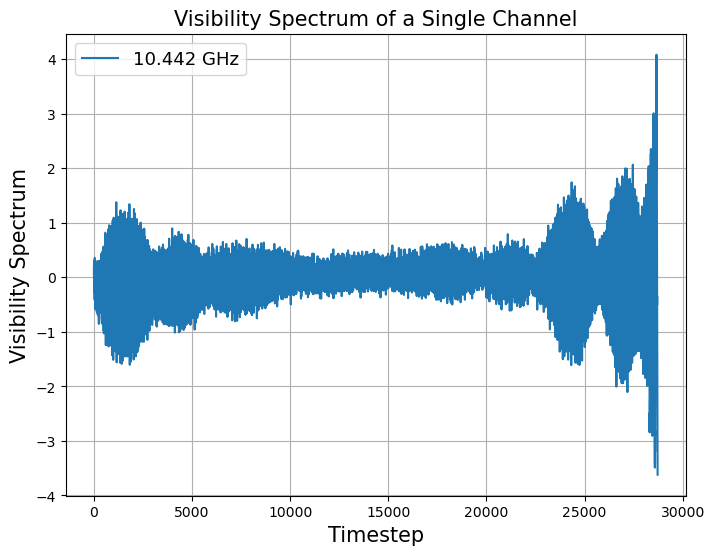

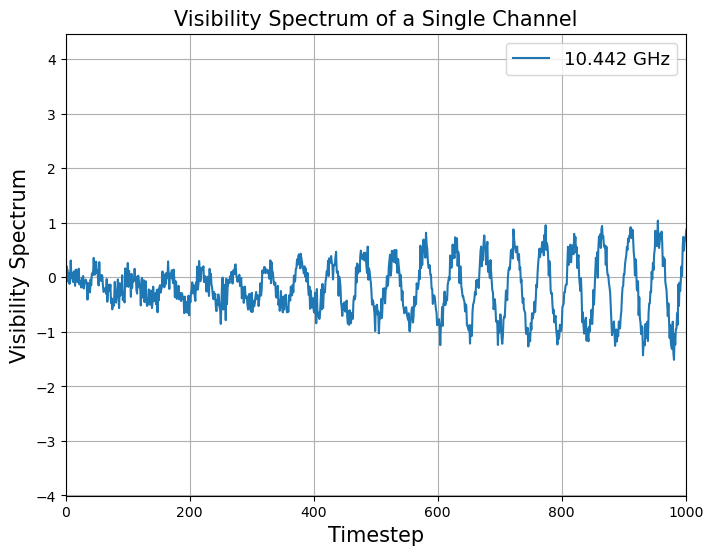

In [14]:
def graphSingleChannelOverTime(data, channel=600, xlim=None, ylim=None):
    # 450 < channel < 800
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])

    plt.plot(channel_data, label=f"10.442 GHz")
    plt.xlabel("Timestep", fontsize=axisSize)
    plt.ylabel("Visibility Spectrum", fontsize=axisSize)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend(fontsize=legendSize)
    plt.title(f"Visibility Spectrum of a Single Channel", size=titleSize)
    plt.grid()
    plt.show()

def graphSingleChannelOverTimeZooms(data, channel=600, xlim=None, ylim=None):
    # 450 < channel < 800
    fig, ax = plt.subplots(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])

    ax.plot(channel_data, label=f"10.442 GHz")
    ax.set_xlabel("Timestep", fontsize=axisSize)
    ax.set_ylabel("Visibility Spectrum", fontsize=axisSize)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(fontsize=legendSize)
    ax.title(f"Visibility Spectrum of a Single Channel", size=titleSize)

graphSingleChannelOverTime(horizon_complex, channel=600)
graphSingleChannelOverTime(horizon_complex, channel=600, xlim=(0, 1000))

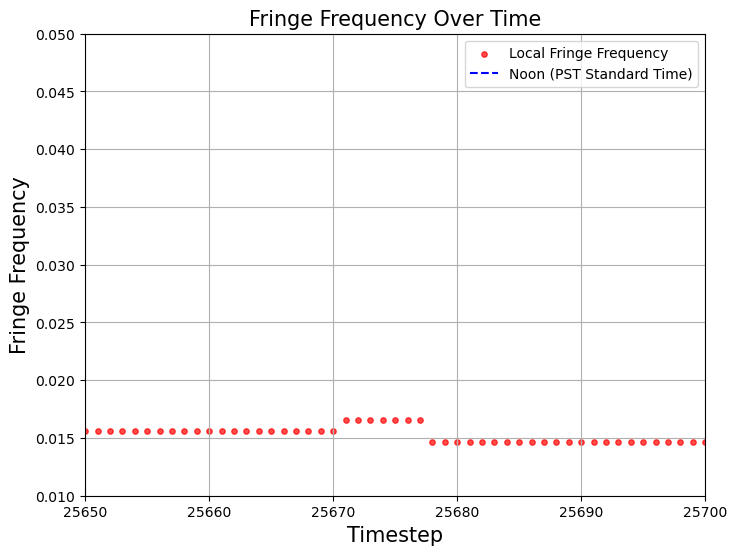

array([0.01658537, 0.01658537, 0.01658537, ..., 0.01073171, 0.01073171,
       0.01073171])

In [15]:
def graphOverlayPowerSpectra(data, sample_rate, channel=600, indices=[5000, 10000, 20000, 25000], window=100, xlim=None):
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])

    for index in indices:
        spectrum = np.abs(fftshift(fft(channel_data[index-window:index+window]))) ** 2
        freqs = fftshift(fftfreq(len(spectrum), sample_rate))
        plt.plot(freqs, spectrum, label=f"Time Index = {index}", alpha=0.7)
   
    plt.xlim(xlim)
    plt.xlabel("Frequency (Hz)", fontsize=axisSize)
    plt.ylabel("Power (Arbitary Scale)", fontsize=axisSize)
    plt.title(f"Power Spectra at Different Times", size=titleSize)
    plt.legend()
    plt.grid(True)
    plt.show()

def graphFringeFreqOverTime(data, sample_rate=1.25, channel=600, resampling=True, window=300, vertical_line=None, xlim=None, ylim=None):
    plt.figure(figsize=graphSizeSingle)
    channel_data = normalize(data[:, channel])
    #channel_data = channel_data[:27000]

    indices = np.linspace(window+1, len(channel_data)-(window+1), len(channel_data)-2*(window+1), dtype=int)
    max_freqs = np.zeros(len(channel_data)-2*(window+1))


    for i, index in enumerate(indices):
        spectrum = np.abs(fftshift(fft(channel_data[index-window:index+window]))) ** 2        
        freqs = fftshift(fftfreq(len(spectrum), d=sample_rate))

        bad_mask = (freqs >= -0.00) & (freqs <= 0.003)
        good_mask = ~bad_mask
        max_freq = np.abs(freqs[np.argmax(spectrum[good_mask])])
        if max_freq < 0.01 or max_freq > 0.07:
            max_freqs[i] = max_freqs[i-1]
        else:
            max_freqs[i] = max_freq

    # Accounting for weird vertical lines in data when it should be smooth
    if resampling:
        max_freqs[11100:11225] = max_freqs[11090]
        max_freqs[11225:11350] = max_freqs[11360]

    plt.scatter(indices, max_freqs, color='r', alpha=0.7, s=15, label="Local Fringe Frequency")
   
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.xlabel("Timestep", fontsize=axisSize)
    plt.ylabel("Fringe Frequency", fontsize=axisSize)
    plt.title(f"Fringe Frequency Over Time", size=titleSize)
    plt.grid(True)
    if vertical_line is not None:
        plt.axvline(x=vertical_line, linestyle='--', color='blue', label=f'Noon (PST Standard Time)')
        plt.legend()
    plt.show()

    return max_freqs


#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[13000, 14000, 15000], channel=600, xlim=(-0.07, 0.07))
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[13000, 14000, 15000], channel=609, xlim=(-0.07, 0.07))

#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[6000, 7000, 8000, 9000, 10000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[11000, 12000, 13000, 14000, 15000], window=200, channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[16000, 17000, 18000, 19000, 20000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[21000, 22000, 23000, 24000, 25000], channel=600, xlim=(0, 0.06))
#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[26000, 27000, 28000], channel=600, xlim=(0, 0.06))

#graphOverlayPowerSpectra(horizon_imag, sample_rate=1.25, indices=[14000, 19000], window=200, channel=600, xlim=(0.028, 0.04))

#graphFringeFreqOverTime(horizon_imag, sample_rate=1.25, channel=600, mask=False, vertical_line=10769, ylim=(0, 0.07))
#graphFringeFreqOverTime(horizon_imag, sample_rate=1.25, channel=600, mask=True, vertical_line=107969, ylim=(0, 0.07))

noon_timestep = 10769+2079 # PST, Daylight Savings accounting 
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=100, channel=600, xlim=(-0.1, 0.1))
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=250, channel=600, xlim=(-0.1, 0.1))
#graphOverlayPowerSpectra(horizon_complex, sample_rate=1.25, indices=[11001, 15000], window=300, channel=600, xlim=(-0.1, 0.1))

#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=325, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=335, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=345, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=350, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=355, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=360, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=365, vertical_line=noon_timestep, ylim=(0.01, 0.07))
#graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=370, vertical_line=noon_timestep, ylim=(0.01, 0.07))
graphFringeFreqOverTime(horizon_complex, sample_rate=1.25, channel=600, window=410, vertical_line=noon_timestep, resampling=False, xlim=(25650, 25700), ylim=(0.01, 0.05))

In [16]:
time_data_jd = getTimesJD(data_horizon_raw_2)
time_data_utc = getTimesLocal(data_horizon_raw_2)
print("Started Mar 15, 8:32:19 AM PST")
print("Ended Mar 15, 6:30:41 PM PST")
print("Difference of 9hr, 58 mins, 22 sec (or 35902 total sec)")
print("28720 time steps")
print("1.25 seconds per time step")

Started Mar 15, 8:32:19 AM PST
Ended Mar 15, 6:30:41 PM PST
Difference of 9hr, 58 mins, 22 sec (or 35902 total sec)
28720 time steps
1.25 seconds per time step


In [17]:
time_data = getUnixTimes(data_horizon_raw_2, buffer=0)
time_data_jd = getTimesJD(data_horizon_raw_2, buffer=0)
LOC = EarthLocation(lat=37.873199*u.deg, lon=-122.257063*u.deg, height=120*u.m)
times = Time(time_data, format='unix', location=LOC)
LSTs = times.sidereal_time('apparent', longitude=LOC.lon).radian

RAs, DECs, HAs = np.zeros(len(time_data)), np.zeros(len(time_data)), np.zeros(len(time_data))
for i in range(len(time_data)):
    ra, dec = ugradio.coord.sunpos(time_data_jd[i])
    RAs[i] = np.radians(ra)
    HAs[i] = LSTs[i] - np.radians(ra)
    DECs[i] = np.radians(dec)

In [18]:
c=299792458
RF = 10.441484375e9 # 10.542 GHz
wavelen = c / RF

w_earth = (2 * np.pi) / (24 * 60 * 60)
#wavelen = 0.025
#wavelen = 0.0285516627
#wavelen = 0.0299792458
L = np.radians(37.873199)
b_ew_guess = 20
b_ns_guess = 0

def constructDesignMatrix(indices, observed_fringe_freqs, HAs, DECs, L, w_earth, wavelen, good_mask=None, undersample=False, step=5):
    if good_mask is None:
        good_mask = np.ones_like(indices, dtype=bool)

    indices_clean = indices[good_mask]
    HAs_clean = HAs[indices_clean]
    DECs_clean = DECs[indices_clean]
    observed_fringe_clean = np.array(observed_fringe_freqs)[good_mask]

    if undersample:
        indices_clean = indices_clean[::step]
        HAs_clean = HAs_clean[::step]
        DECs_clean = DECs_clean[::step]
        observed_fringe_clean = observed_fringe_clean[::step]

    A = (1 / wavelen) * np.cos(DECs_clean) * np.cos(HAs_clean)
    B = -(1 / wavelen) * np.sin(L) * np.cos(DECs_clean) * np.sin(HAs_clean)
    X = np.vstack([A, B]).T
    y = np.array(observed_fringe_clean) / w_earth

    return X, y, indices_clean, HAs_clean, DECs_clean, observed_fringe_clean

In [19]:
def fit_baseline_least_squares(X, y, initial_guess=(20.0, 0.0)):    
    def residuals(beta, X, y):
        b_ew, b_ns = beta
        return X @ np.array([b_ew, b_ns]) - y

    #lower_bounds = (14, -1)
    #upper_bounds = (20, 0.5)
    result = least_squares(residuals, initial_guess, args=(X, y))#, bounds=(lower_bounds, upper_bounds))
    
    # Estimate covariance and errors
    residuals_vec = result.fun
    N, p = len(y), 2
    sigma2 = np.sum(residuals_vec**2) / (N - p)
    cov = sigma2 * np.linalg.inv(X.T @ X)
    errors = np.sqrt(np.diag(cov))
    chi2_red = sigma2

    print(N)

    return result.x, errors, chi2_red, result

Window = 410


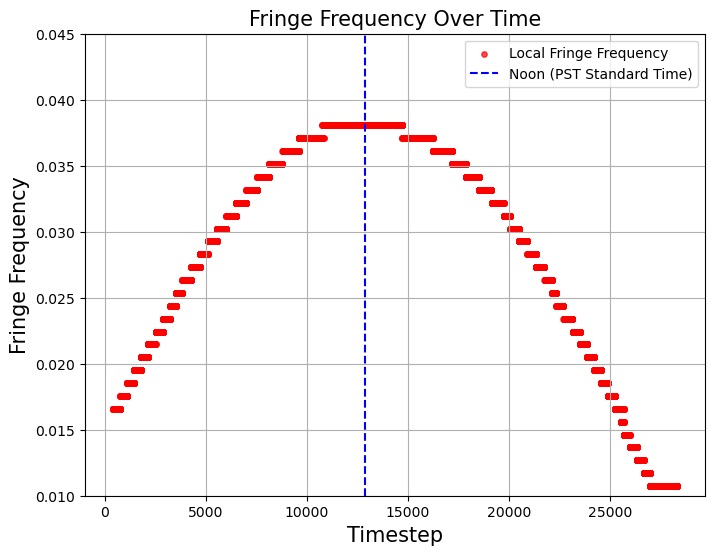

timestep 0: observed = 0.0165854, estimated = 0.0164426
timestep 5000: observed = 0.0292683, estimated = 0.0357994
timestep 10000: observed = 0.0370732, estimated = 0.0478837
timestep 15000: observed = 0.0370732, estimated = 0.0502401
timestep 20000: observed = 0.0302439, estimated = 0.0423896
timestep 25000: observed = 0.0165854, estimated = 0.0259267
2658
b_ew = 15.084 ± 0.003 m
b_ns = 1.460 ± 0.006 m
Reduced chi-squared = 18.441


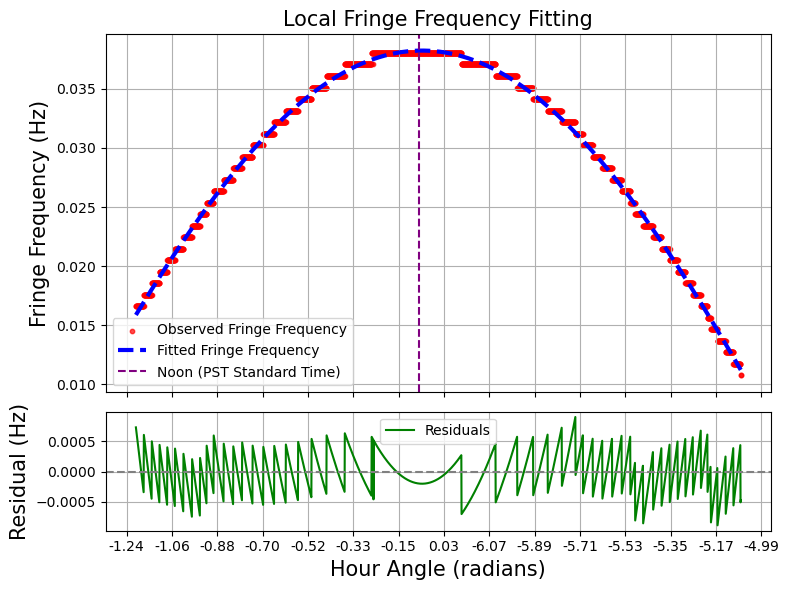

In [20]:

#for window in range(390, 421, 5):
for window in range(410, 411, 5):
    print(f"Window = {window}")
    observed_fringe_freqs = graphFringeFreqOverTime(horizon_complex, channel=600, window=window, resampling=True, vertical_line=noon_timestep, ylim=(0.01, 0.045))
    indices = np.linspace(window+1, len(horizon_complex)-(window+1), len(horizon_complex)-2*(window+1), dtype=int)

    max_timestep = 27000
    bad_mask = (indices > 25670) & (indices < 25680)
    valid_mask = (indices < max_timestep) & ~bad_mask

    X, y, indices_clean, HAs_clean, DECs_clean, observed_fringe_clean = constructDesignMatrix(
        indices, observed_fringe_freqs, HAs, DECs, L, w_earth, wavelen, good_mask=valid_mask, undersample=True, step=10
    )
    
    estimated_fringe_freqs = []
    Q_ew = (b_ew_guess / wavelen) * np.cos(DECs)
    Q_ns = (b_ns_guess / wavelen) * np.sin(L) * np.cos(DECs)
    estimated_fringe_freqs = (Q_ew * np.cos(HAs) - Q_ns * np.sin(HAs)) * w_earth

    steps = 5000
    for i in range(0, len(observed_fringe_freqs), steps):
        obs = round(observed_fringe_freqs[i], 7)
        est = round(estimated_fringe_freqs[i], 7)
        print(f"timestep {i}: observed = {obs}, estimated = {est}")

    b_ew_init_guess = b_ew_guess
    b_ns_init_guess = b_ns_guess
    beta, errors, chi2_red, result_obj = fit_baseline_least_squares(X, y, initial_guess=(b_ew_init_guess, b_ns_init_guess))
    b_ew, b_ns = beta

    print(f"b_ew = {b_ew:.3f} ± {errors[0]:.3f} m")
    print(f"b_ns = {b_ns:.3f} ± {errors[1]:.3f} m")
    print(f"Reduced chi-squared = {chi2_red:.3f}")

    Q_ew = (b_ew / wavelen) * np.cos(DECs_clean)
    Q_ns = (b_ns / wavelen) * np.sin(L) * np.cos(DECs_clean)
    estimated = (Q_ew * np.cos(HAs_clean) - Q_ns * np.sin(HAs_clean)) * w_earth

    fig, ax = plt.subplots(2, 1, figsize=graphSizeSingle, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

    ax[0].scatter(indices_clean, y * w_earth, alpha=0.7, color='r', s=10, label='Observed Fringe Frequency')
    ax[0].plot(indices_clean, estimated, label='Fitted Fringe Frequency', linestyle='--', color='blue', linewidth=3)
    ax[0].axvline(noon_timestep, linestyle='--', color='purple', label='Noon (PST Standard Time)')
    ax[0].set_ylabel('Fringe Frequency (Hz)', fontsize=axisSize)
    ax[0].set_title('Local Fringe Frequency Fitting', size=titleSize)
    ax[0].legend()
    ax[0].grid(True)

    xticks = np.linspace(0, len(indices)-1, 15, dtype=int)
    xlabels = HAs[xticks]
    for i in range(len(xlabels)):
        if xlabels[i] > 2:
            xlabels[i] -= 2 * np.pi

    residuals = (y * w_earth) - estimated
    ax[1].plot(indices_clean, residuals, label='Residuals', color='green')
    ax[1].axhline(0, linestyle='--', color='gray')
    ax[1].set_xticks(xticks, [f"{val:.2f}" for val in xlabels])
    ax[1].set_xlabel('Hour Angle (radians)', fontsize=axisSize)
    ax[1].set_ylabel('Residual (Hz)', fontsize=axisSize)
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


# Frequency Channel 600, Window 410

# No Undersampling
# b_ew = 15.084 ± 0.001 m
# b_ns = 1.459 ± 0.002 m
# Reduced chi-squared = 18.446

# Undersampling (step=10)
# b_ew = 15.084 ± 0.003 m
# b_ns = 1.460 ± 0.006 m
# Reduced chi-squared = 18.441

NOTES:  

dont do absolute value, keep real and complex data and find way to fix systematics (misalignment)?

waterfall plot for angle flip axes

non perfect bessel func bc not perfect disk (sun spot delta -> (FFT) -> flat function / baseline instead of 0)

Baseline used: b_ew = 15.088 m, b_ns = 1.372 m
Best-fit theta: 4.991834e-03 ± 1.2e-04 rad
Diameter: 34.32 ± 0.80 arcmin
Reduced chi-squared: 1.502


c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


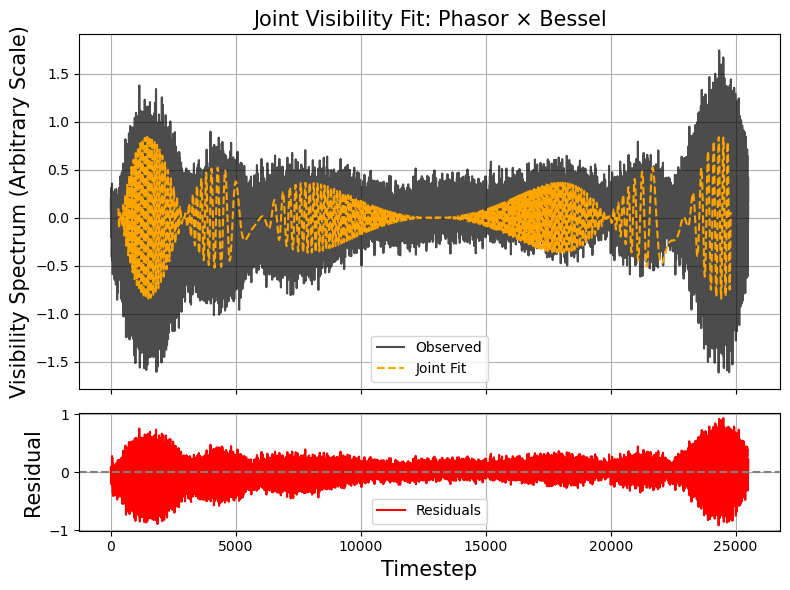

In [54]:
def get_source_unit_vector(ra, dec, jd):
    # Both should be in radians
    alt, az = ugradio.coord.get_altaz(np.degrees(ra), np.degrees(dec), jd)
    alt_rad = np.radians(alt)
    az_rad = np.radians(az)

    l = np.cos(alt_rad) * np.sin(az_rad)
    m = np.sin(alt_rad)
    n = np.sqrt(1 - l**2 - m**2)
    return l, m, n

def get_baseline_unit_vector(b_ew, b_ns, has):
    # b_ew and b_ns should be in meters, has in radians
    u = (b_ew * np.cos(has)) / wavelen
    v = (b_ns * np.sin(has)) / wavelen
    w = (b_ew * np.sin(has) + b_ns * np.cos(has)) / wavelen
    return u, v, w

def joint_vis_model(b_ew, b_ns, ra, ha, dec, theta_rad, jd, scale_real=1.0, scale_imag=0.0):
    # b_ew and b_ns should be in meters, ra and ha and dec in radians
    u, v, w = get_baseline_unit_vector(b_ew, b_ns, ha)
    l, m, n = get_source_unit_vector(ra, dec, jd)

    dot_product = u * l + v * m + w * n
    approximation = b_ew * np.cos(ha)
    fringe_phasor = np.exp(-1j * (2 * np.pi) * (dot_product))
    #fringe_phasor = np.exp(-1j * (2 * np.pi) * (approximation))

    x = 2 * np.pi * theta_rad * np.sqrt(u**2 + v**2)
    bessel = np.ones_like(x)
    bessel[x == 0] = 1.0
    bessel[x != 0] = 2 * j1(x[x != 0]) / x[x!= 0]
    
    scale = scale_real + 1j * scale_imag

    return scale * fringe_phasor * bessel

def residuals(params, data, b_ew, b_ns, ras, has, decs, jd):
    theta_rad, scale_real, scale_imag = params

    model_vis = joint_vis_model(b_ew, b_ns, ras, has, decs, theta_rad, jd, scale_real, scale_imag)

    return np.concatenate([
        (model_vis.real - data.real),
        (model_vis.imag - data.imag)
    ])

c = 3e8
w_earth = (2 * np.pi) / (24 * 60 * 60)

channel = 600
channel_data = horizon_complex[:, channel]

baselines = [(15.088, 1.372)]
#baselines = [(15.084, 1.460)]
c=299792458
RF = 10.441484375e9 # 10.441 GHz
wavelen = c / RF
cutoff = 25500

for b_ew, b_ns in baselines:
    init_theta = 0.00465
    init_scale_real = 1
    init_scale_imag = 0

    # # Get index where HA is closest to 0 (transit)
    # transit_idx = np.argmin(np.abs(HAs))
    # window = 13000  # or whatever gives you ~[-2, 2] radians of HA

    # # Create symmetric slice
    # cut_idx = slice(transit_idx - window//2, transit_idx + window//2)

    # # Apply to all inputs
    # data_cut = channel_data[cut_idx]
    # ha_cut = HAs[cut_idx]
    # ra_cut = RAs[cut_idx]
    # dec_cut = DECs[cut_idx]
    # jd_cut = time_data_jd[cut_idx]


    result = least_squares(
        residuals,
        x0=[init_theta, init_scale_real, init_scale_imag],
        args=(channel_data[:cutoff], b_ew, b_ns, RAs[:cutoff], HAs[:cutoff], DECs[:cutoff], time_data_jd[:cutoff])
        #args=(data_cut, b_ew, b_ns, ra_cut, ha_cut, dec_cut, jd_cut)
    )

    # Extract the Jacobian and compute the covariance matrix
    J = result.jac
    residuals_vec = result.fun
    N = 25500
    p = 2  # Number of fitted parameters (theta, scale)

    # Estimate residual variance (reduced chi-squared)
    sigma2 = np.sum(residuals_vec**2) / (N - p)
    cov = sigma2 * inv(J.T @ J)
    theta_std = np.sqrt(cov[0, 0])  # 1-sigma error in theta

    # Convert to diameter in arcminutes
    theta_best = result.x[0]
    scale_real = result.x[1]
    scale_imag = result.x[2]
    diameter = 2 * np.degrees(theta_best) * 60
    diameter_err = 2 * np.degrees(theta_std) * 60

    print(f"Baseline used: b_ew = {b_ew:.3f} m, b_ns = {b_ns:.3f} m")
    print(f"Best-fit theta: {theta_best:.6e} ± {theta_std:.1e} rad")
    print(f"Diameter: {diameter:.2f} ± {diameter_err:.2f} arcmin")
    print(f"Reduced chi-squared: {sigma2:.3f}")

    model_vis = joint_vis_model(b_ew, b_ns, RAs[:cutoff], HAs[:cutoff], DECs[:cutoff], theta_best, time_data_jd[:cutoff], scale_real, scale_imag)

    #old_indices = np.arange(len(model_vis[1000:-500]))
    #new_indices = np.linspace(0, len(model_vis[1000:-500])-1, cutoff)
    #stretched_data = np.interp(new_indices, old_indices, model_vis[1000:-500])

    norm_data = normalize(channel_data[:cutoff])
    
    residuals_data = normalize(channel_data[:cutoff]) - (model_vis*1.6)
    residuals_shifted = np.zeros(cutoff)
    #for i in range(cutoff-1):
    #    if (i >= 300) or (i + 700 >= cutoff) :
    #        residuals_shifted[i] = norm_data[i] - (model_vis[i+700]*1.6)
    #residuals_data = normalize(channel_data[:cutoff]) - model_vis_adjusted

    model_vis /= np.abs(model_vis).max()
    residuals_data /= np.abs(residuals_data).max()

    # --- Plot: Joint Fit with Residuals ---
    fig, ax = plt.subplots(2, 1, figsize=graphSizeSingle, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    shifted_x = np.linspace(300, 24800, len(model_vis[1000:]))

    # Top: Model and Observed
    ax[0].plot(normalize(channel_data[:cutoff]), label='Observed', color='black', alpha=0.7)
    ax[0].plot(shifted_x, model_vis[1000:]*1.6, label='Joint Fit', linestyle='--', color='orange')
    #ax[0].plot(model_vis_adjusted, label='Joint Fit', linestyle='--', color='orange')
    ax[0].set_ylabel("Visibility Spectrum (Arbitrary Scale)", fontsize=axisSize)
    ax[0].set_title('Joint Visibility Fit: Phasor × Bessel', fontsize=titleSize)
    ax[0].legend()
    ax[0].grid(True)

    # Bottom: Residuals
    ax[1].plot(residuals_data, label='Residuals', color='red')
    #ax[1].plot(residuals_shifted, label='Residuals', color='red')
    ax[1].axhline(0, linestyle='--', color='gray')
    ax[1].set_xlabel('Timestep', fontsize=axisSize)
    ax[1].set_ylabel('Residual', fontsize=axisSize)
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()

# Baseline used: b_ew = 15.088 m, b_ns = 1.372 m
# Best-fit theta: 4.934403e-03 ± 1.3e-04 rad
# Diameter: 33.93 ± 0.90 arcmin
# Reduced chi-squared: 1.498

25500 25500 25500


C:\Users\brand\AppData\Local\Temp\ipykernel_13084\1837976214.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  residuals_shifted[i] = norm_data[i] - (model_vis_cut[i-300]*1.6)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\brand\anaconda3\Lib\site-packages\matplotlib\cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


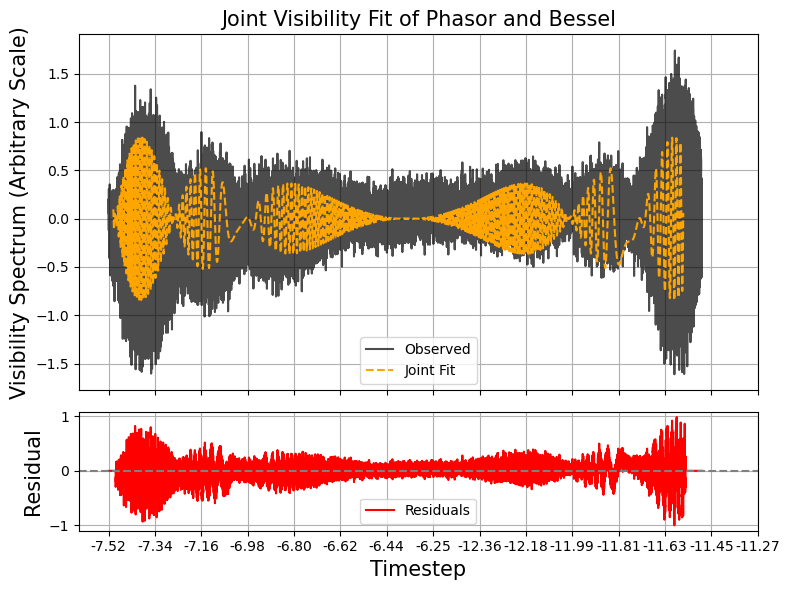

In [ ]:
residuals_shifted = np.zeros(cutoff)

print(len(residuals_shifted), len(norm_data), len(model_vis))

model_vis_cut = model_vis[1000:]

for i in range(len(norm_data)):
    if (i >= 300) and (i < 24800):
        residuals_shifted[i] = norm_data[i] - (model_vis_cut[i-300]*1.6)
    #residuals_data = normalize(channel_data[:cutoff]) - model_vis_adjusted
residuals_shifted /= np.abs(residuals_shifted).max()

fig, ax = plt.subplots(2, 1, figsize=graphSizeSingle, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
shifted_x = np.linspace(200, 24700, len(model_vis[1000:]))

# Top: Model and Observed
ax[0].plot(normalize(channel_data[:cutoff]), label='Observed', color='black', alpha=0.7)
ax[0].plot(shifted_x, model_vis_cut*1.6, label='Joint Fit', linestyle='--', color='orange')
#ax[0].plot(model_vis_adjusted, label='Joint Fit', linestyle='--', color='orange')
ax[0].set_ylabel("Visibility Spectrum (Arbitrary Scale)", fontsize=axisSize)
ax[0].set_title('Joint Visibility Fit of Phasor and Bessel', fontsize=titleSize)
ax[0].legend()
ax[0].grid(True)

xticks = np.linspace(0, len(indices)-1, 15, dtype=int)
xlabels = HAs[xticks]
#for i in range(len(xlabels)):
#    if xlabels[i] < 2:
#        xlabels[i] -= 2 * np.pi

# Bottom: Residuals
#ax[1].plot(residuals_data, label='Residuals', color='red')
ax[1].plot(residuals_shifted, label='Residuals', color='red')
ax[1].axhline(0, linestyle='--', color='gray')
ax[1].set_xticks(xticks, [f"{val:.2f}" for val in xlabels])
ax[1].set_xlabel('Timestep', fontsize=axisSize)
ax[1].set_ylabel('Residual', fontsize=axisSize)
ax[1].legend()
ax[1].grid(True)
plt.tight_layout()
plt.show()